# Final Project for Adaptive Decision Making
### Modeling Behavioral Data from Attentiveness Study with DDM
Group Members: Oscar, Emilio, and William

### Do all of our main imports first

In [1]:
from __future__ import division
from ADMCode import visualize as vis

import numpy as np
import pandas as pd
import numba as nb

from numba.decorators import jit
from numpy.random import random_sample
from numba import float64, int64, vectorize, boolean

from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline

### Create a single decision barrier DDM

In [2]:
@jit(nb.typeof((1.0, 1.0))(float64[:], float64[:], float64[:]), nopython=True)
def sim_ddm(parameters, rProb, trace):

    # extract parameters
    a, tr, v, z, si, dx, dt = parameters

    # convert drift-rate into a probability,
    # & scale by sigma (si) and timestep (dt)
    # if v > 0, then 0.5 < vProb < 1.0
    # if v < 0, then 0.0 < vProb < 0.5
    vProb = .5 * (1 + (v * np.sqrt(dt))/si)

    # define starting point with respect to boundary height
    zStart = z * a

    #initialize evidence variable at zStart
    evidence = zStart
    trace[0] = evidence

    # define deadline (max time allowed for accumulation)
    deadline = trace.size

    for nsteps in range(1, deadline):
        # sample a random probability (r) and compare w/ vProb
        if rProb[nsteps] < vProb:
            # if r < vProb, step evidence up (towards a)
            evidence += dx
        else:
            # if r > vProb, step evidence down (towards 0)
            evidence -= dx

        if evidence < zStart:
            evidence = zStart
            
        # store new value of evidence at current timestep
        trace[nsteps] = evidence
            
        if evidence >= a:
            # calculate RT (in milliseconds)
            rt = tr + (nsteps * dt)
            # set choice to 1.0 (upper bound)
            choice = 1.0

            # terminate simulation, return rt & choice
            return rt, choice

    # return -1.0 for rt and choice so we can filter out
    # trials where evidence never crossed 0 or a
    return -1.0, -1.0

### Background code for running DDM and generating dataframes

In [3]:
def gen_ddm_storage_objects(parameters, ntrials=200, deadline=1.5):
    dt = parameters[-1]
    ntime = np.int(np.floor(deadline / dt))
    data = np.zeros((ntrials, 2))
    rProb = random_sample((ntrials, ntime))
    traces = np.zeros_like(rProb)
    return data, rProb, traces

def clean_output(data, traces, deadline=1.2, stimulus=None):
    df = pd.DataFrame(data, columns=['rt', 'choice'])
    df.insert(0, 'trial', np.arange(1, 1+df.shape[0]))
    df = df[(df.rt>0)&(df.rt<deadline)]
    traces = traces[df.index.values, :]
    df = df.reset_index(drop=True)
    return df, traces

@jit((float64[:], float64[:,:], float64[:,:], float64[:,:]), nopython=True)
def _sim_ddm_trials_(parameters, data, rProb, traces):
    ntrials = data.shape[0]
    for t in range(ntrials):
        data[t, :] = sim_ddm(parameters, rProb[t], traces[t])

def sim_ddm_trials(parameters, ntrials=500, deadline=1.5, decay=False):
    data, rProb, traces = gen_ddm_storage_objects(parameters, ntrials, deadline)
    _sim_ddm_trials_(parameters, data, rProb, traces)
    df, traces = clean_output(data, traces, deadline=deadline)
    return df, traces

### Set our parameters
We can begin with a regular DDM (with one boundary) and tweak with the parameters or potentially add more parameters to get this best fit to the behavioral data that we have

In [4]:
a = 1 # boundary height
v = .15 # drift-rate
tr = 0 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)

dt = .01 # time stepsize
si = .1 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence stepsize (up/down)
deadline = 60 # max decision time (in sec)
ntrials = 46 # number of trials to simulate

parameters = np.array([a, tr, v, z, si, dx, dt])

In [5]:
df, traces = sim_ddm_trials(parameters, ntrials, deadline)
df.head()

,trial,rt,choice
0,1,7.78,1.0
1,2,8.28,1.0
2,3,5.79,1.0
3,4,6.79,1.0
4,5,5.37,1.0


In [6]:
accuracy = df.choice.mean()
corRT = df[df.choice==1].rt.mean()

print("RT (cor) = {:.0f} ms".format(corRT/dt))
print("Accuracy = {:.0f}%".format(accuracy*100))

RT (cor) = 634 ms
Accuracy = 100%


### Visualization of single barrier DDM

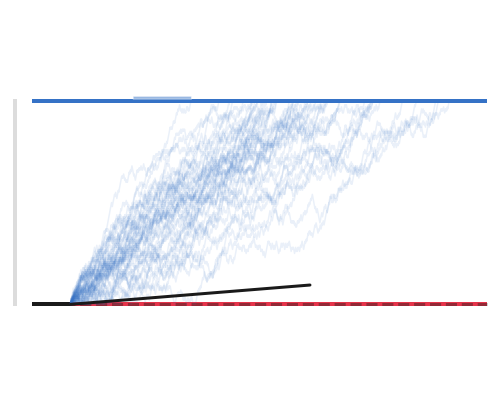

In [7]:
ax = vis.plot_ddm_sims(df, parameters, traces=traces, plot_v=True)

### Create a single decision barrier DDM with attention decay

In [8]:
@jit(nb.typeof((1.0, 1.0))(float64[:], float64[:], float64[:]), nopython=True)
def sim_decay_ddm(parameters, rProb, trace):
    # extract parameters
    a, tr, v, z, si, dx, dt, decay, decay_acceleration = parameters

    # convert drift-rate into a probability,
    # & scale by sigma (si) and timestep (dt)
    # if v > 0, then 0.5 < vProb < 1.0
    # if v < 0, then 0.0 < vProb < 0.5
    vProb = .5 * (1 + (v * np.sqrt(dt))/si)

    # define starting point with respect to boundary height
    zStart = z * a

    #initialize evidence variable at zStart
    evidence = zStart
    trace[0] = evidence

    # define deadline (max time allowed for accumulation)
    deadline = trace.size

    for nsteps in range(1, deadline):
        # sample a random probability (r) and compare w/ vProb
        if rProb[nsteps] < vProb:
            # if r < vProb, step evidence up (towards a)
            evidence += dx
        else:
            # if r > vProb, step evidence down (towards 0)
            evidence -= dx

        # always add in decay parameter
        evidence -= decay
            
        if evidence < zStart:
            evidence = zStart
            
        # store new value of evidence at current timestep
        trace[nsteps] = evidence
            
        if evidence >= a:
            # calculate RT (in milliseconds)
            rt = tr + (nsteps * dt)
            # set choice to 1.0 (upper bound)
            choice = 1.0

            # terminate simulation, return rt & choice
            return rt, choice

    # return -1.0 for rt and choice so we can filter out
    # trials where evidence never crossed 0 or a
    return -1.0, -1.0

### Background code for running decay DDM and generating dataframes

In [12]:
@jit((float64[:], float64[:,:], float64[:,:], float64[:,:]), nopython=True)
def _sim_decay_ddm_trials_(parameters, data, rProb, traces):
    ntrials = data.shape[0]
    for t in range(ntrials):
        a, tr, v, z, si, dx, dt, decay, decay_acceleration = parameters
        decay += decay_acceleration
        parameters_decay = np.array([a, tr, v, z, si, dx, dt, decay, decay_acceleration])
        data[t, :] = sim_decay_ddm(parameters, rProb[t], traces[t])

def sim_decay_ddm_trials(parameters, ntrials=500, deadline=1.5, decay=False):
    data, rProb, traces = gen_ddm_storage_objects(parameters, ntrials, deadline)
    _sim_decay_ddm_trials_(parameters, data, rProb, traces)
    df, traces = clean_output(data, traces, deadline=deadline)
    return df, traces

In [13]:
a = 1 # boundary height
v = .15 # drift-rate
tr = 0 # nondecision time (in seconds)
z = 0 # starting point ([0,1], fraction of a)
decay = 0.0005
decay_acceleration = 0.0001

dt = .01 # time stepsize
si = .1 # sigma (noise scalar)
dx = si * np.sqrt(dt) # evidence stepsize (up/down)
deadline = 60 # max decision time (in sec)
ntrials = 46 # number of trials to simulate

parameters_decay = np.array([a, tr, v, z, si, dx, dt, decay, decay_acceleration])

In [14]:
df, traces = sim_decay_ddm_trials(parameters_decay, ntrials, deadline)
df.head()

,trial,rt,choice
0,1,5.44,1.0
1,2,9.15,1.0
2,3,7.99,1.0
3,4,11.05,1.0
4,5,14.43,1.0


In [15]:
accuracy = df.choice.mean()
corRT = df[df.choice==1].rt.mean()

print("RT (cor) = {:.0f} ms".format(corRT/dt))
print("Accuracy = {:.0f}%".format(accuracy*100))

RT (cor) = 908 ms
Accuracy = 100%
